Data: sampleLasso descriptions, tissue ground truth of a subset.  
Goal: explore how ground truth derives (->) best threshold and predicted annotations  

Ground truth: the true labels used to train txt2onto models.  
Best threshold: various cut off methods used on the predictions (probabilities) from txt2onto models.  
predicted annotation: the classified binary annotation by applying the best threshold.  
1. ground truth (x) -> best threshold (y): explore how the best threshild is compared to the ground truth from which the best threshold is generated.  
2. best threshold (x) -> predicted annotation (y): explore how the predicted annotation is compared to the best threshild from which the predicted annotion is generated.  

Date: 2025-11-17  
Author: Junxia Lin  

In [ ]:
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import polars as pl

In [3]:
# import the data
prior_df = pd.read_csv("../data/true_label__inst_type=sample__task=tissue.csv.gz", compression="gzip", sep=",")
ic_df = pd.read_csv("../data/UBERON_IC.csv", sep=",")
log2auprc_df = pd.read_csv("../data/tissue_model_stats.csv", sep=",")
id_map = pl.read_parquet("../data/UBERON_CL_id_map.parquet")
id_map = id_map.to_pandas()

folder_path = "../results/sampleLasso"
threshold_files = glob.glob(os.path.join(folder_path, "*_best_threshold.csv"))
threshold_dfs = [pd.read_csv(file, sep = "\t") for file in threshold_files]
annotation_analysis_files = glob.glob(os.path.join(folder_path, "threshold_annotation_analysis_*.csv"))
annotation_analysis_dfs = [pd.read_csv(file, sep=",") for file in annotation_analysis_files]

In [4]:
threshold_files, annotation_analysis_files

(['../results/sampleLasso/Balanced_accuracy_best_threshold.csv',
  '../results/sampleLasso/MCC_best_threshold.csv',
  '../results/sampleLasso/f1.0_best_threshold.csv',
  '../results/sampleLasso/f0.5_best_threshold.csv'],
 ['../results/sampleLasso/threshold_annotation_analysis_f05.csv',
  '../results/sampleLasso/threshold_annotation_analysis_MCC.csv',
  '../results/sampleLasso/threshold_annotation_analysis_Balanced_accuracy.csv',
  '../results/sampleLasso/threshold_annotation_analysis_f1.csv'])

In [5]:
threshold_dfs[0]["method"] = "balanced_accuracy"
threshold_dfs[1]["method"] = "mcc"
threshold_dfs[2]["method"] = "f1"
threshold_dfs[3]["method"] = "f05"
threshold_df = pd.concat(threshold_dfs, ignore_index=True)
threshold_df["log2(best_th/prior)"] = np.log2(threshold_df["best_threshold"]/threshold_df["prior"])
threshold_df = threshold_df.merge(id_map, left_on="task", right_on="id", how="left")
threshold_df = threshold_df.drop(columns=["id"])
threshold_df.head()

,task,best_threshold,prior,log2(auprc/prior),method,log2(best_th/prior),name
0,UBERON:0002435,0.002185,0.000643,9.795344,balanced_accuracy,1.764367,striatum
1,UBERON:0000955,0.063902,0.036658,4.621508,balanced_accuracy,0.801725,brain
2,UBERON:0002020,0.020251,0.013537,5.415666,balanced_accuracy,0.581062,gray matter
3,UBERON:0000165,0.005485,0.030945,4.945225,balanced_accuracy,-2.496126,mouth
4,CL:0000576,0.047798,0.006200,7.121328,balanced_accuracy,2.946733,monocyte


In [6]:
annotation_analysis_dfs[0]["method"] = "f05"
annotation_analysis_dfs[1]["method"] = "mcc"
annotation_analysis_dfs[2]["method"] = "balanced_accuracy"
annotation_analysis_dfs[3]["method"] = "f1"
annotation_analysis_df = pd.concat(annotation_analysis_dfs, ignore_index=True)
annotation_analysis_df = annotation_analysis_df.merge(id_map, left_on="task", right_on="id", how="left")
annotation_analysis_df = annotation_analysis_df.drop(columns=["id"])
annotation_analysis_df.head()

,task,best_threshold,prior,num_of_pos,num_of_pred_pos,method,name
0,UBERON:0002435,0.002176,0.000577,18,33,f05,striatum
1,UBERON:0000955,0.282196,0.034763,1138,3667,f05,brain
2,UBERON:0002020,0.963025,0.013443,427,22,f05,gray matter
3,UBERON:0000165,0.373765,0.030977,951,262,f05,mouth
4,CL:0000576,0.363368,0.006238,166,504,f05,monocyte


In [77]:
threshold_df["method"].value_counts(), annotation_analysis_df["method"].value_counts()

(method
 balanced_accuracy    231
 mcc                  231
 f1                   222
 f05                  222
 Name: count, dtype: int64,
 method
 mcc                  231
 balanced_accuracy    231
 f05                  222
 f1                   222
 Name: count, dtype: int64)

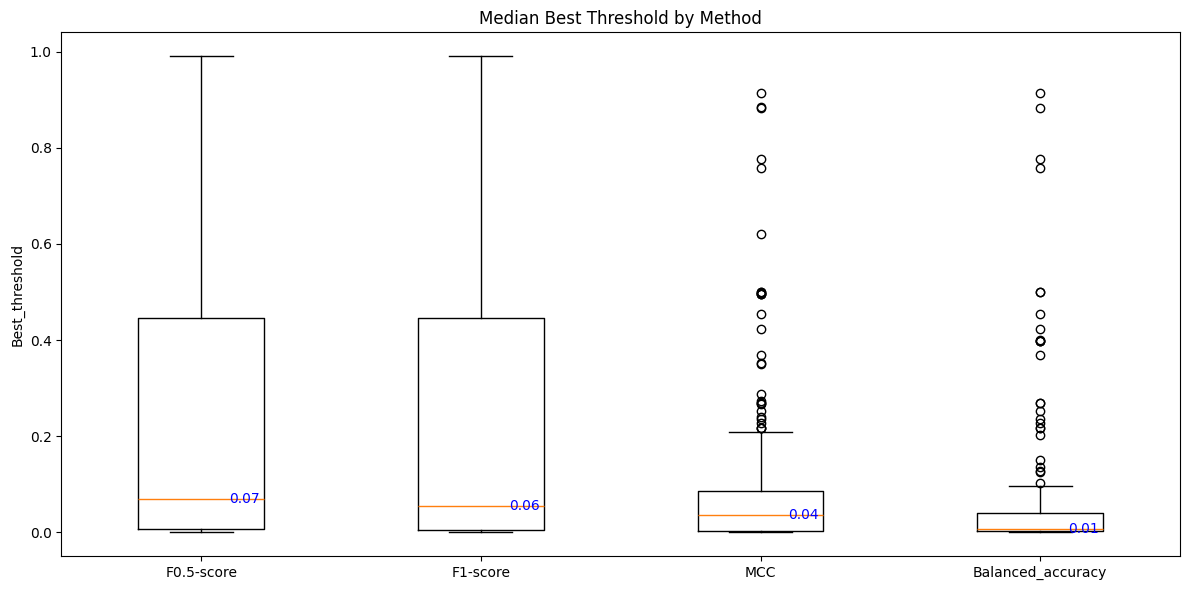

In [7]:
# boxplot for the best threshold
y_axis = "best_threshold"
plt.figure(figsize=(12, 6))
plt.boxplot([threshold_df[threshold_df["method"] == "f05"][y_axis], threshold_df[threshold_df["method"] == "f1"][y_axis], threshold_df[threshold_df["method"] == "mcc"][y_axis], threshold_df[threshold_df["method"] == "balanced_accuracy"][y_axis]])
median_value_f05 = threshold_df[threshold_df["method"] == "f05"][y_axis].median()
median_value_f1 = threshold_df[threshold_df["method"] == "f1"][y_axis].median()
median_value_mcc = threshold_df[threshold_df["method"] == "mcc"][y_axis].median()
median_value_ba = threshold_df[threshold_df["method"] == "balanced_accuracy"][y_axis].median()
plt.text(1.1, median_value_f05, f"{median_value_f05:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.text(2.1, median_value_f1, f"{median_value_f1:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.text(3.1, median_value_mcc, f"{median_value_mcc:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.text(4.1, median_value_ba, f"{median_value_ba:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.xticks([1, 2, 3, 4], ['F0.5-score', 'F1-score', 'MCC', 'Balanced_accuracy'])
plt.ylabel(y_axis.capitalize())
plt.title("Median Best Threshold by Method")
plt.tight_layout()
# Show the plot
plt.show()

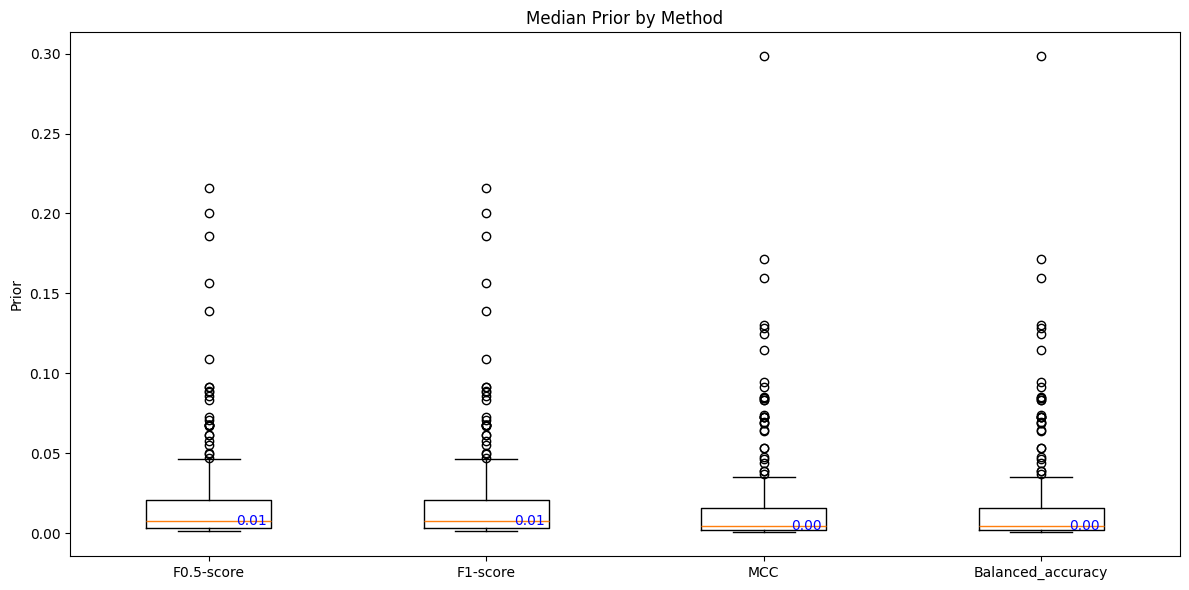

In [8]:
# boxplot for prior
y_axis = "prior"
plt.figure(figsize=(12, 6))
plt.boxplot([threshold_df[threshold_df["method"] == "f05"][y_axis], threshold_df[threshold_df["method"] == "f1"][y_axis], threshold_df[threshold_df["method"] == "mcc"][y_axis], threshold_df[threshold_df["method"] == "balanced_accuracy"][y_axis]])
median_value_f05 = threshold_df[threshold_df["method"] == "f05"][y_axis].median()
median_value_f1 = threshold_df[threshold_df["method"] == "f1"][y_axis].median()
median_value_mcc = threshold_df[threshold_df["method"] == "mcc"][y_axis].median()
median_value_ba = threshold_df[threshold_df["method"] == "balanced_accuracy"][y_axis].median()
plt.text(1.1, median_value_f05, f"{median_value_f05:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.text(2.1, median_value_f1, f"{median_value_f1:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.text(3.1, median_value_mcc, f"{median_value_mcc:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.text(4.1, median_value_ba, f"{median_value_ba:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.xticks([1, 2, 3, 4], ['F0.5-score', 'F1-score', 'MCC', 'Balanced_accuracy'])
plt.ylabel(y_axis.capitalize())
plt.title("Median Prior by Method")
plt.tight_layout()
# Show the plot
plt.show()

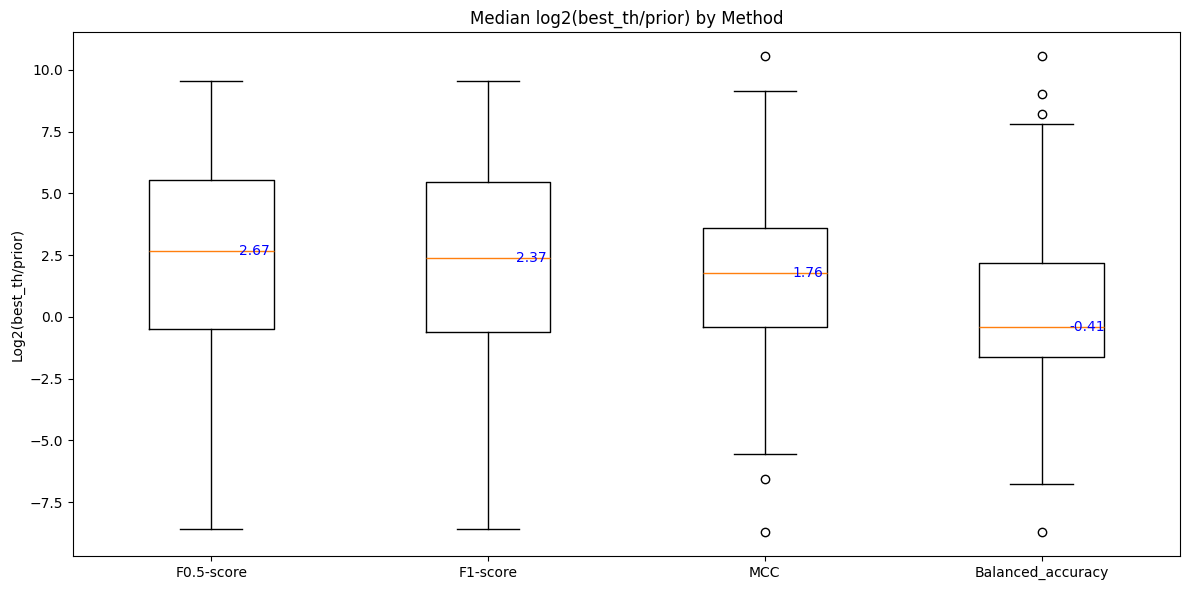

In [9]:
# boxplot for the best threshold/prior log2 ratio
y_axis = "log2(best_th/prior)"
plt.figure(figsize=(12, 6))
plt.boxplot([threshold_df[threshold_df["method"] == "f05"][y_axis], threshold_df[threshold_df["method"] == "f1"][y_axis], threshold_df[threshold_df["method"] == "mcc"][y_axis], threshold_df[threshold_df["method"] == "balanced_accuracy"][y_axis]])
median_value_f05 = threshold_df[threshold_df["method"] == "f05"][y_axis].median()
median_value_f1 = threshold_df[threshold_df["method"] == "f1"][y_axis].median()
median_value_mcc = threshold_df[threshold_df["method"] == "mcc"][y_axis].median()
median_value_ba = threshold_df[threshold_df["method"] == "balanced_accuracy"][y_axis].median()
plt.text(1.1, median_value_f05, f"{median_value_f05:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.text(2.1, median_value_f1, f"{median_value_f1:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.text(3.1, median_value_mcc, f"{median_value_mcc:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.text(4.1, median_value_ba, f"{median_value_ba:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.xticks([1, 2, 3, 4], ['F0.5-score', 'F1-score', 'MCC', 'Balanced_accuracy'])
plt.ylabel(y_axis.capitalize())
plt.title("Median log2(best_th/prior) by Method")
plt.tight_layout()
# Show the plot
plt.show()

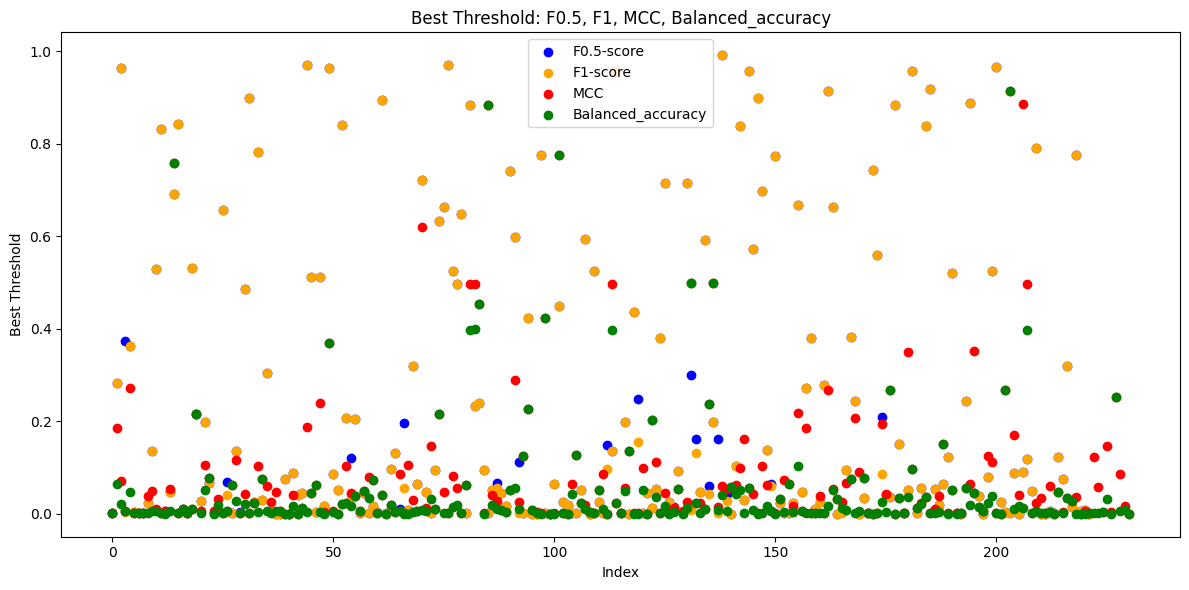

In [24]:
# scatter plot: best_threshold
plt.figure(figsize=(12,6))
plt.scatter(threshold_df[threshold_df["method"] == "f05"].reset_index().index, threshold_df[threshold_df["method"] == "f05"]["best_threshold"], label='F0.5-score', c="blue")
plt.scatter(threshold_df[threshold_df["method"] == "f1"].reset_index().index, threshold_df[threshold_df["method"] == "f1"]["best_threshold"], label='F1-score', c="orange")
plt.scatter(threshold_df[threshold_df["method"] == "mcc"].reset_index().index, threshold_df[threshold_df["method"] == "mcc"]["best_threshold"], label='MCC', c="red")
plt.scatter(threshold_df[threshold_df["method"] == "balanced_accuracy"].reset_index().index, threshold_df[threshold_df["method"] == "balanced_accuracy"]["best_threshold"], label='Balanced_accuracy', c="green")
plt.xlabel("Index")
plt.ylabel("Best Threshold")
plt.title("Best Threshold: F0.5, F1, MCC, Balanced_accuracy")
plt.legend()
plt.tight_layout()
# Show the plot
plt.show()

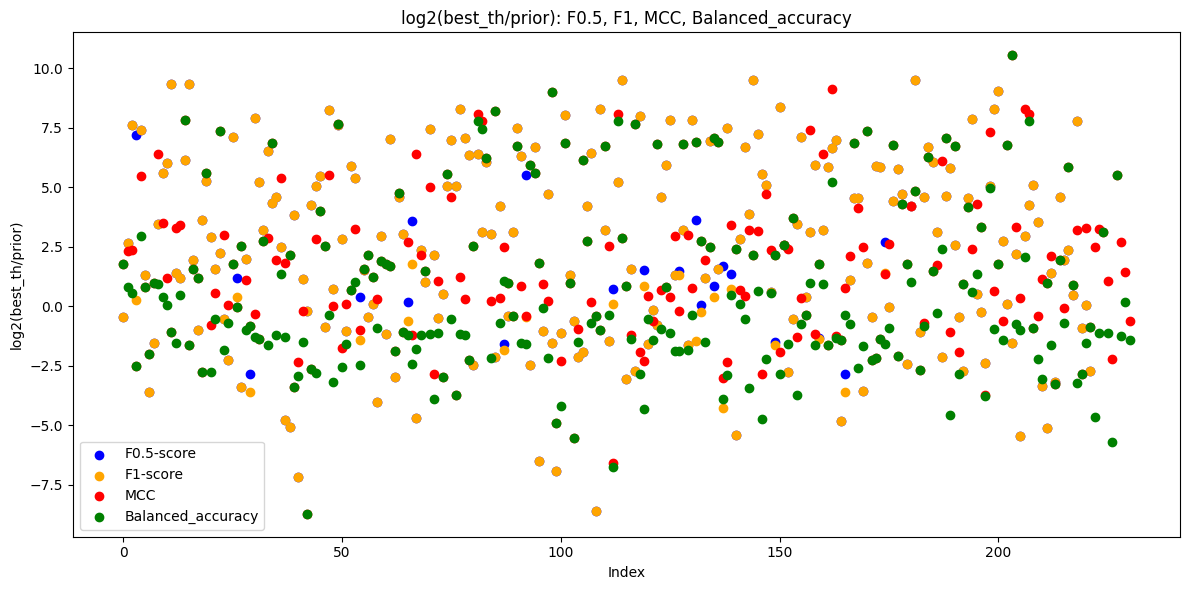

In [25]:
# scatter plot: log2(best_th/prior)
plt.figure(figsize=(12,6))
plt.scatter(threshold_df[threshold_df["method"] == "f05"].reset_index().index, threshold_df[threshold_df["method"] == "f05"]["log2(best_th/prior)"], label='F0.5-score', c="blue")
plt.scatter(threshold_df[threshold_df["method"] == "f1"].reset_index().index, threshold_df[threshold_df["method"] == "f1"]["log2(best_th/prior)"], label='F1-score', c="orange")
plt.scatter(threshold_df[threshold_df["method"] == "mcc"].reset_index().index, threshold_df[threshold_df["method"] == "mcc"]["log2(best_th/prior)"], label='MCC', c="red")
plt.scatter(threshold_df[threshold_df["method"] == "balanced_accuracy"].reset_index().index, threshold_df[threshold_df["method"] == "balanced_accuracy"]["log2(best_th/prior)"], label='Balanced_accuracy', c="green")
plt.xlabel("Index")
plt.ylabel("log2(best_th/prior)")
plt.title("log2(best_th/prior): F0.5, F1, MCC, Balanced_accuracy")
plt.legend()
plt.tight_layout()
# Show the plot
plt.show()

In [ ]:
# the top terms with the highest threshold
threshold_df_top10_f05 = threshold_df[threshold_df["method"] == "f05"].sort_values(by="best_threshold", ascending = False)["name"].head(10)
threshold_df_top10_f1 = threshold_df[threshold_df["method"] == "f1"].sort_values(by="best_threshold", ascending = False)["name"].head(10)
threshold_df_top10_mcc = threshold_df[threshold_df["method"] == "mcc"].sort_values(by="best_threshold", ascending = False)["name"].head(10)
threshold_df_top10_ba = threshold_df[threshold_df["method"] == "balanced_accuracy"].sort_values(by="best_threshold", ascending = False)["name"].head(10)

In [32]:
threshold_df_top10_f05, threshold_df_top10_f1

(822                             cerebral cortex
 760                          reproductive gland
 728                     male reproductive gland
 884                               temporal lobe
 686                                 gray matter
 733    central nervous system cell part cluster
 865                            olfactory cortex
 828                             piriform cortex
 798                       parahippocampal gyrus
 869                         upper urinary tract
 Name: name, dtype: object,
 600                             cerebral cortex
 538                          reproductive gland
 506                     male reproductive gland
 662                               temporal lobe
 464                                 gray matter
 511    central nervous system cell part cluster
 643                            olfactory cortex
 606                             piriform cortex
 576                       parahippocampal gyrus
 647                         upper urinar

In [33]:
threshold_df_top10_mcc, threshold_df_top10_ba

(434            thyroid gland
 437           dendritic cell
 316           arterial blood
 332          alveolar system
 245           frontal cortex
 301                   t cell
 367    tracheobronchial tree
 362                 bronchus
 313        blood vasculature
 312                     vein
 Name: name, dtype: object,
 203            thyroid gland
 85            arterial blood
 101          alveolar system
 14            frontal cortex
 136    tracheobronchial tree
 131                 bronchus
 83          respiratory tube
 98           urinary bladder
 82         blood vasculature
 81                      vein
 Name: name, dtype: object)

In [56]:
# the top terms with the highest prior
annotation_analysis_df_top10_f05 = annotation_analysis_df[annotation_analysis_df["method"] == "f05"].sort_values(by="prior", ascending = False)["name"].head(10)
annotation_analysis_df_top10_f1 = annotation_analysis_df[annotation_analysis_df["method"] == "f1"].sort_values(by="prior", ascending = False)["name"].head(10)
annotation_analysis_df_top10_mcc = annotation_analysis_df[annotation_analysis_df["method"] == "mcc"].sort_values(by="prior", ascending = False)["name"].head(10)
annotation_analysis_df_top10_ba = annotation_analysis_df[annotation_analysis_df["method"] == "balanced_accuracy"].sort_values(by="prior", ascending = False)["name"].head(10)

In [57]:
annotation_analysis_df_top10_f05, annotation_analysis_df_top10_f1

(132                                         blood
 149                                     leukocyte
 87                               mononuclear cell
 156                               digestive tract
 112                      digestive system element
 100                subdivision of digestive tract
 131                               skeletal system
 67                                    bone marrow
 51     alimentary part of gastrointestinal system
 157                                     intestine
 Name: name, dtype: object,
 816                                         blood
 833                                     leukocyte
 771                              mononuclear cell
 840                               digestive tract
 796                      digestive system element
 784                subdivision of digestive tract
 815                               skeletal system
 751                                   bone marrow
 735    alimentary part of gastrointestinal system
 84

In [58]:
annotation_analysis_df_top10_mcc, annotation_analysis_df_top10_ba

(360                                         blood
 377                                     leukocyte
 313                              mononuclear cell
 385                               digestive tract
 338                      digestive system element
 326                subdivision of digestive tract
 359                               skeletal system
 293                                   bone marrow
 276    alimentary part of gastrointestinal system
 386                                     intestine
 Name: name, dtype: object,
 591                                         blood
 608                                     leukocyte
 544                              mononuclear cell
 616                               digestive tract
 569                      digestive system element
 557                subdivision of digestive tract
 590                               skeletal system
 524                                   bone marrow
 507    alimentary part of gastrointestinal system
 61

### txt2onto models GT label & performance

In [14]:
# combine the best threshold, prior, ic, pos, logarprc
txt2onto_label_dfs = []
methods = ["f05", "f1", "mcc", "balanced_accuracy"]
for m in methods:
    df = threshold_df[threshold_df["method"] == m]
    prior = []
    ic = []
    pos = []
    auprcprior = []
    for i in df["task"]:
        prior_df_sub = prior_df[["Unnamed: 0", i]]
        prior_df_sub = prior_df_sub[(prior_df_sub != 0).all(axis=1)]
        prior_df_sub[i] = prior_df_sub[i].replace(-1, 0)
        prior.append(prior_df_sub[i].mean())
        ic_value = ic_df.loc[ic_df['node'] == i, 'IC'].values[0]
        ic.append(ic_value)
        pos_value = log2auprc_df.loc[log2auprc_df['ID'] == i, 'num_of_pos'].values[0]
        pos.append(pos_value)
        auprc_value = log2auprc_df.loc[log2auprc_df['ID'] == i, 'log2(auprc/prior)'].values[0]
        auprcprior.append(auprc_value)

    # data used to train txt2onto
    txt2onto_label = pd.DataFrame({"task": df["task"], "best_threshold": df["best_threshold"], "prior": prior, "ic": ic, "num_of_pos": pos, "log2(auprc/prior)": auprcprior})
    txt2onto_label = txt2onto_label.merge(id_map, left_on="task", right_on="id", how="left")
    txt2onto_label = txt2onto_label.drop(columns=["id"])
    txt2onto_label["method"] = m
    txt2onto_label_dfs.append(txt2onto_label)
txt2onto_label_df = pd.concat(txt2onto_label_dfs, ignore_index=True)
txt2onto_label_df.head()
    

,task,best_threshold,prior,ic,num_of_pos,log2(auprc/prior),name,method
0,UBERON:0002435,0.002176,0.000475,6.200953,10,9.390408,striatum,f05
1,UBERON:0000955,0.282196,0.085881,2.067788,2394,3.632799,brain,f05
2,UBERON:0002020,0.963025,0.016515,2.488143,387,3.393686,gray matter,f05
3,UBERON:0000165,0.373765,0.008627,2.936865,286,3.000259,mouth,f05
4,CL:0000576,0.363368,0.011456,7.268793,304,5.531797,monocyte,f05


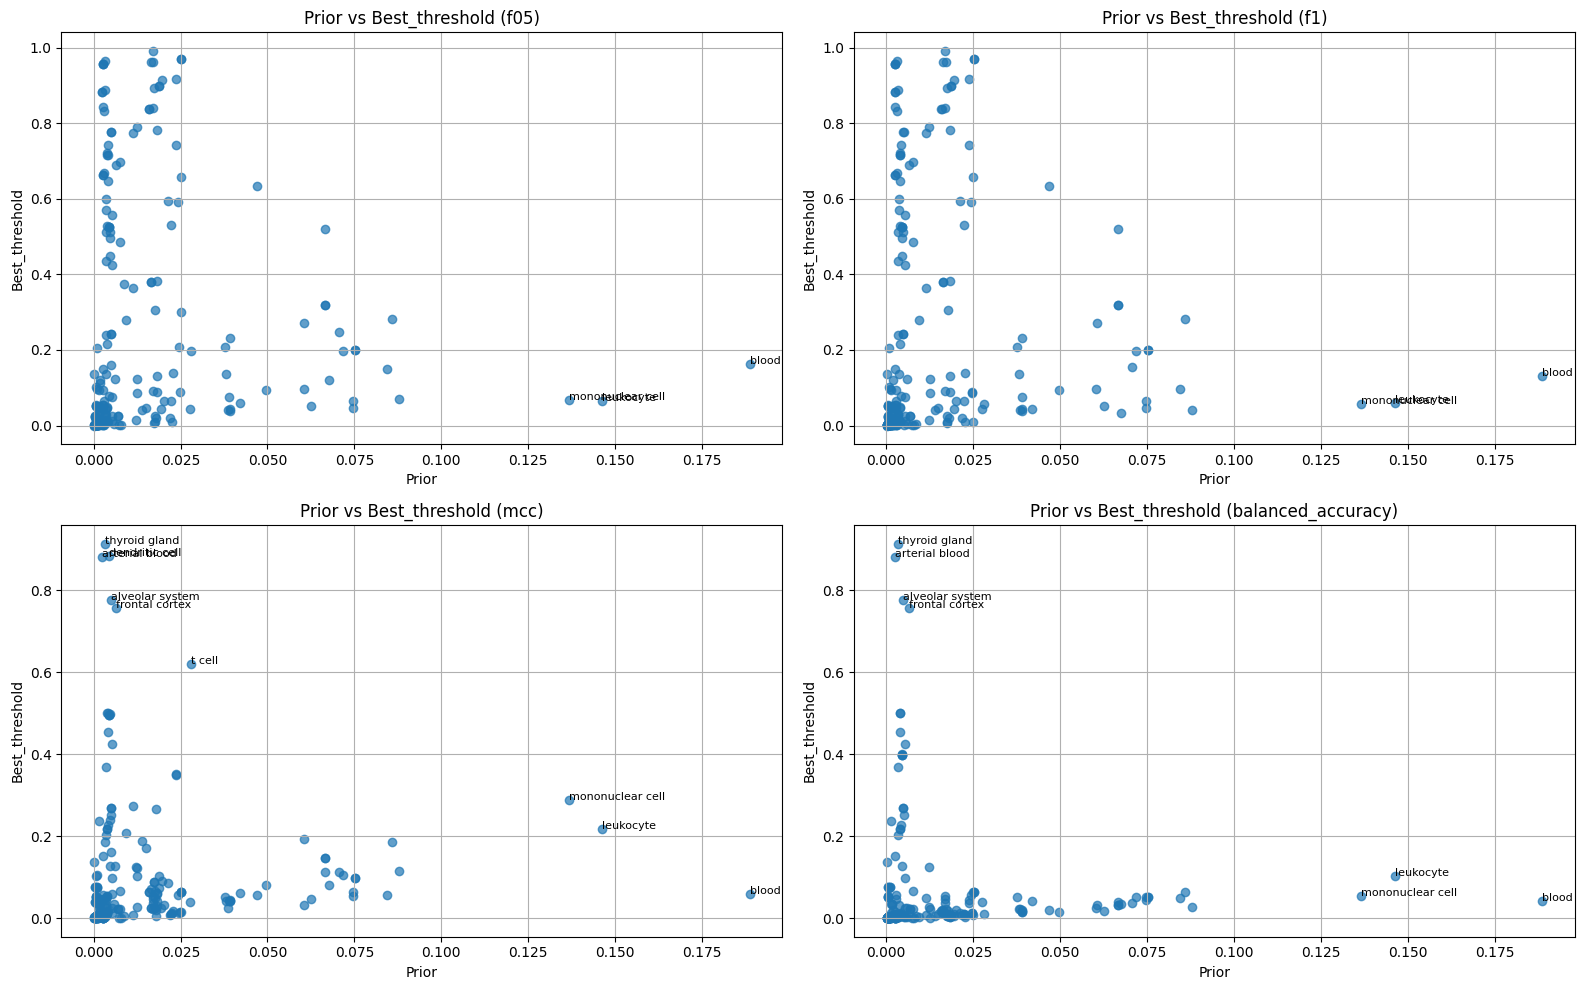

In [15]:
# Prior vs Best Threshold
methods = ["f05", "f1", "mcc", "balanced_accuracy"]
x_axis = "prior"
y_axis = "best_threshold"
plt.figure(figsize=(16, 10))

for i, method in enumerate(methods, 1):
    subset = txt2onto_label_df[txt2onto_label_df["method"] == method]
    plt.subplot(2, 2, i)
    plt.scatter(subset[x_axis], subset[y_axis], alpha=0.7)
    for i, row in subset.iterrows():
        if row[x_axis] > 0.1:
            plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    if method in ["balanced_accuracy", "mcc"]:
        for i, row in subset.iterrows():
            if row[y_axis] > 0.6:
                plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    plt.xlabel(x_axis.capitalize())
    plt.ylabel(y_axis.capitalize())
    plt.title(f'{x_axis.capitalize()} vs {y_axis.capitalize()} ({method})')
    plt.grid(True)

plt.tight_layout()
plt.show()

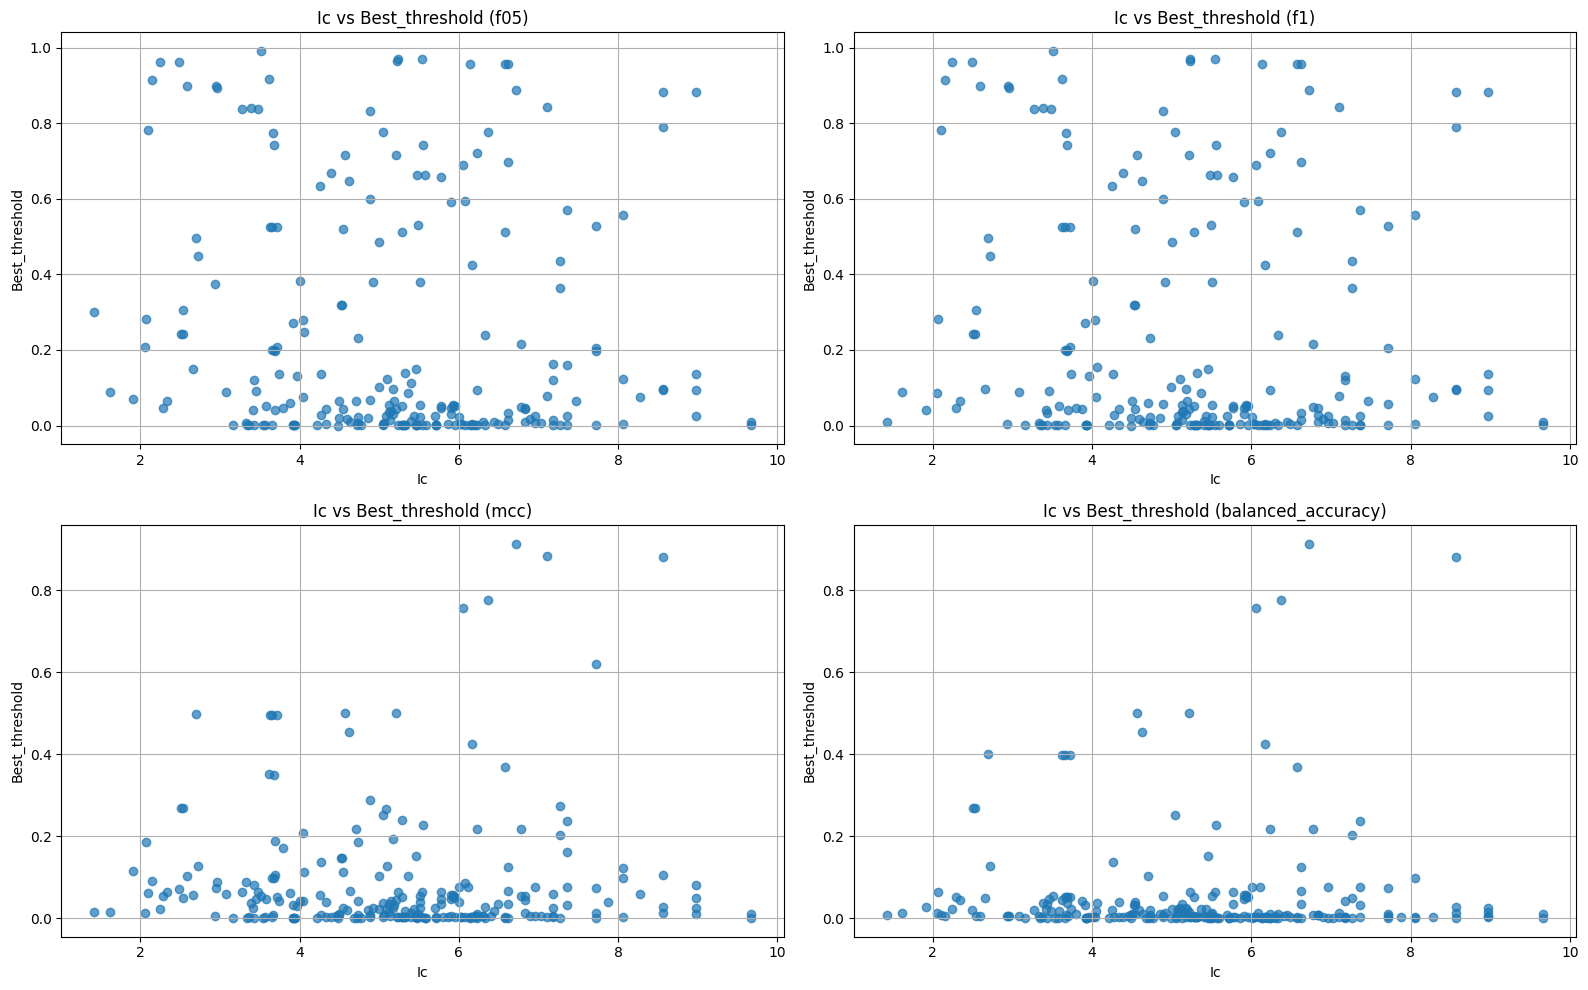

In [16]:
# Information Content vs Best Threshold
methods = ["f05", "f1", "mcc", "balanced_accuracy"]
x_axis = "ic"
y_axis = "best_threshold"
plt.figure(figsize=(16, 10))

for i, method in enumerate(methods, 1):
    subset = txt2onto_label_df[txt2onto_label_df["method"] == method]
    plt.subplot(2, 2, i)
    plt.scatter(subset[x_axis], subset[y_axis], alpha=0.7)
    # for i, row in subset.iterrows():
    #     if row[x_axis] > 0.1:
    #         plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    # if method in ["balanced_accuracy", "mcc"]:
    #     for i, row in subset.iterrows():
    #         if row[y_axis] > 0.6:
    #             plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    plt.xlabel(x_axis.capitalize())
    plt.ylabel(y_axis.capitalize())
    plt.title(f'{x_axis.capitalize()} vs {y_axis.capitalize()} ({method})')
    plt.grid(True)

plt.tight_layout()
plt.show()

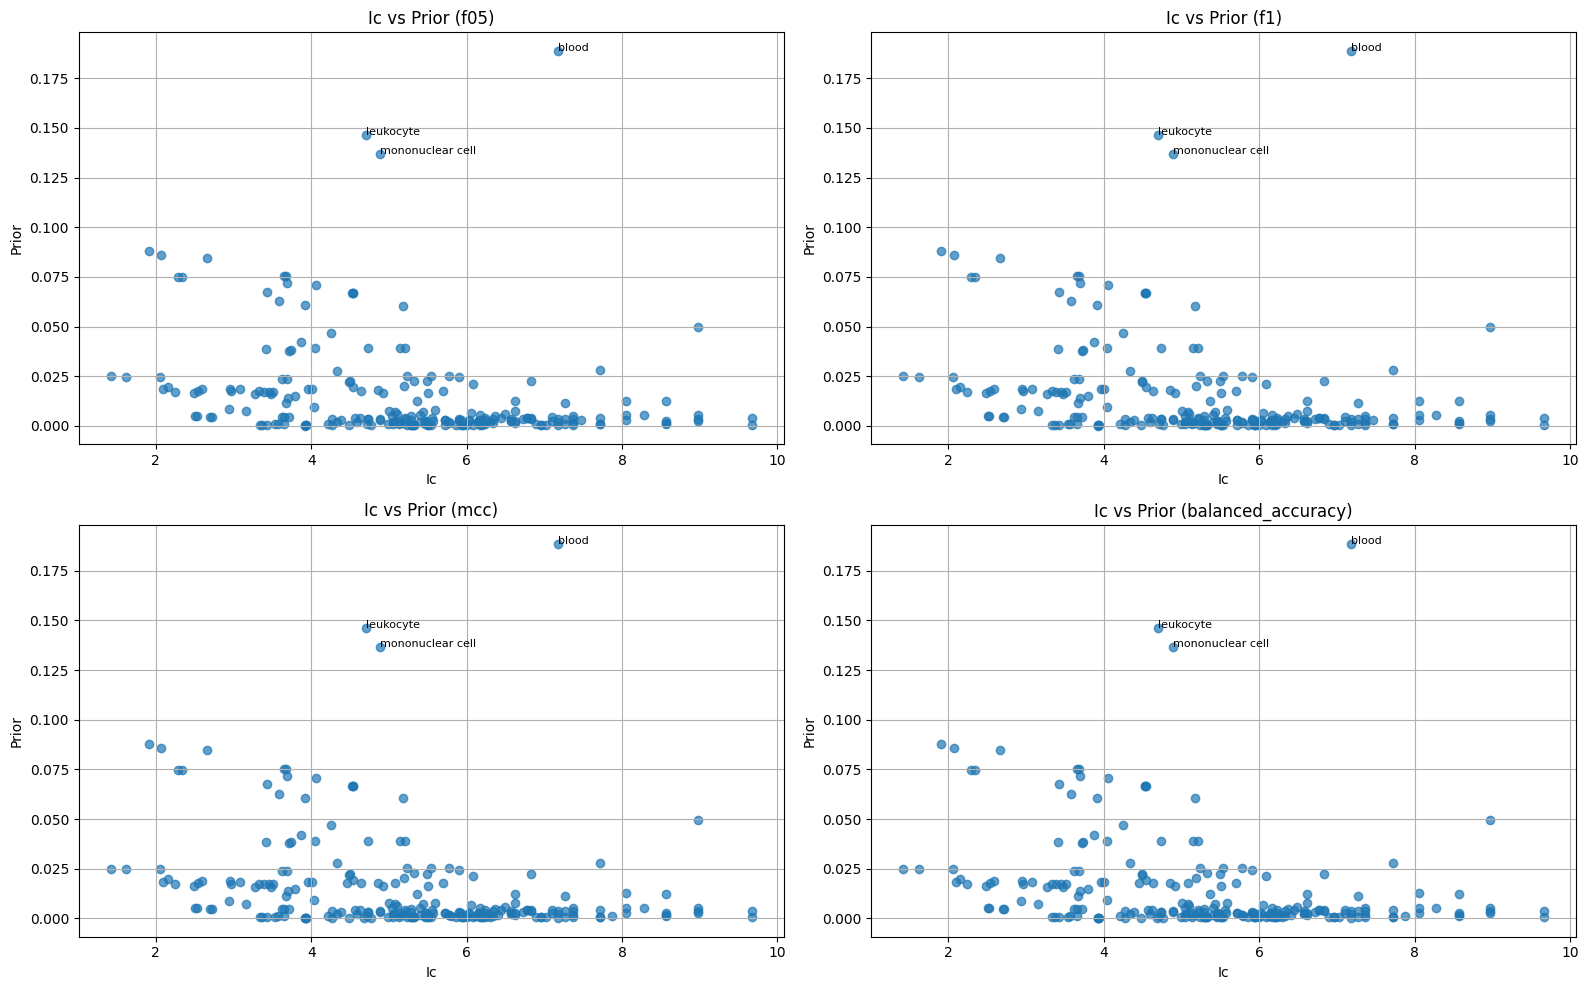

In [17]:
# IC vs Prior
methods = ["f05", "f1", "mcc", "balanced_accuracy"]
x_axis = "ic"
y_axis = "prior"
plt.figure(figsize=(16, 10))

for i, method in enumerate(methods, 1):
    subset = txt2onto_label_df[txt2onto_label_df["method"] == method]
    plt.subplot(2, 2, i)
    plt.scatter(subset[x_axis], subset[y_axis], alpha=0.7)
    for i, row in subset.iterrows():
        if row[y_axis] > 0.1:
            plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    plt.xlabel(x_axis.capitalize())
    plt.ylabel(y_axis.capitalize())
    plt.title(f'{x_axis.capitalize()} vs {y_axis.capitalize()} ({method})')
    plt.grid(True)

plt.tight_layout()
plt.show()

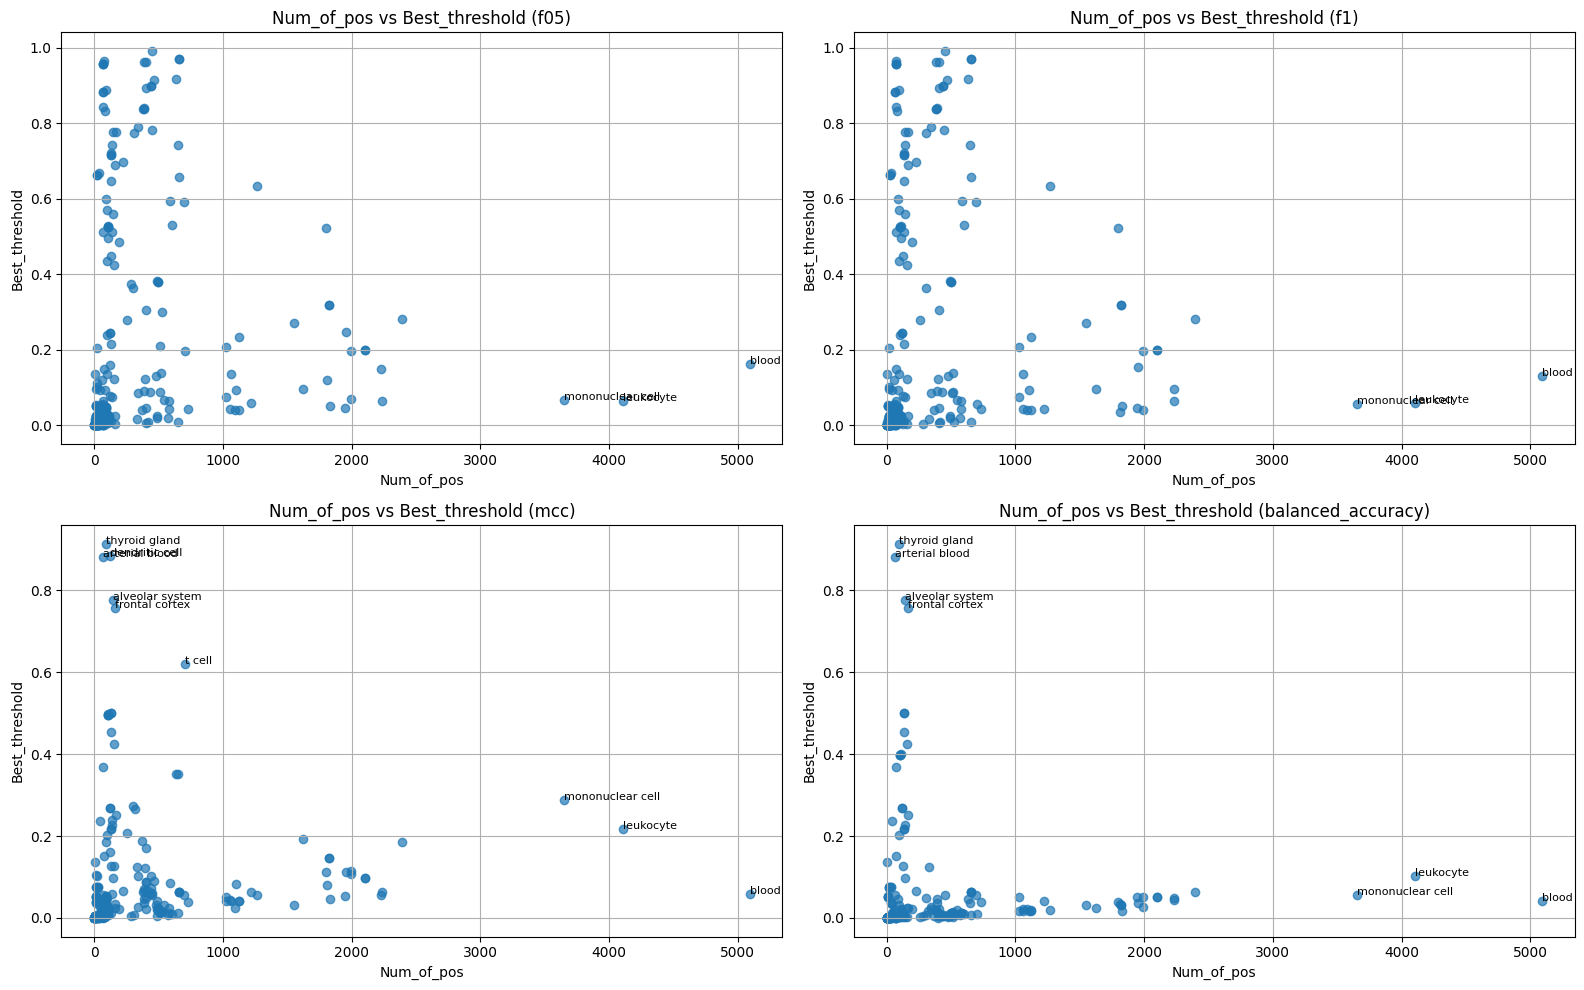

In [18]:
# Number of Positives vs best_threshold
methods = ["f05", "f1", "mcc", "balanced_accuracy"]
x_axis = "num_of_pos"
y_axis = "best_threshold"
plt.figure(figsize=(16, 10))

for i, method in enumerate(methods, 1):
    subset = txt2onto_label_df[txt2onto_label_df["method"] == method]
    plt.subplot(2, 2, i)
    plt.scatter(subset[x_axis], subset[y_axis], alpha=0.7)
    for i, row in subset.iterrows():
        if row[x_axis] > 3000:
            plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    if method in ["balanced_accuracy", "mcc"]:
        for i, row in subset.iterrows():
            if row[y_axis] > 0.6:
                plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    plt.xlabel(x_axis.capitalize())
    plt.ylabel(y_axis.capitalize())
    plt.title(f'{x_axis.capitalize()} vs {y_axis.capitalize()} ({method})')
    plt.grid(True)

plt.tight_layout()
plt.show()

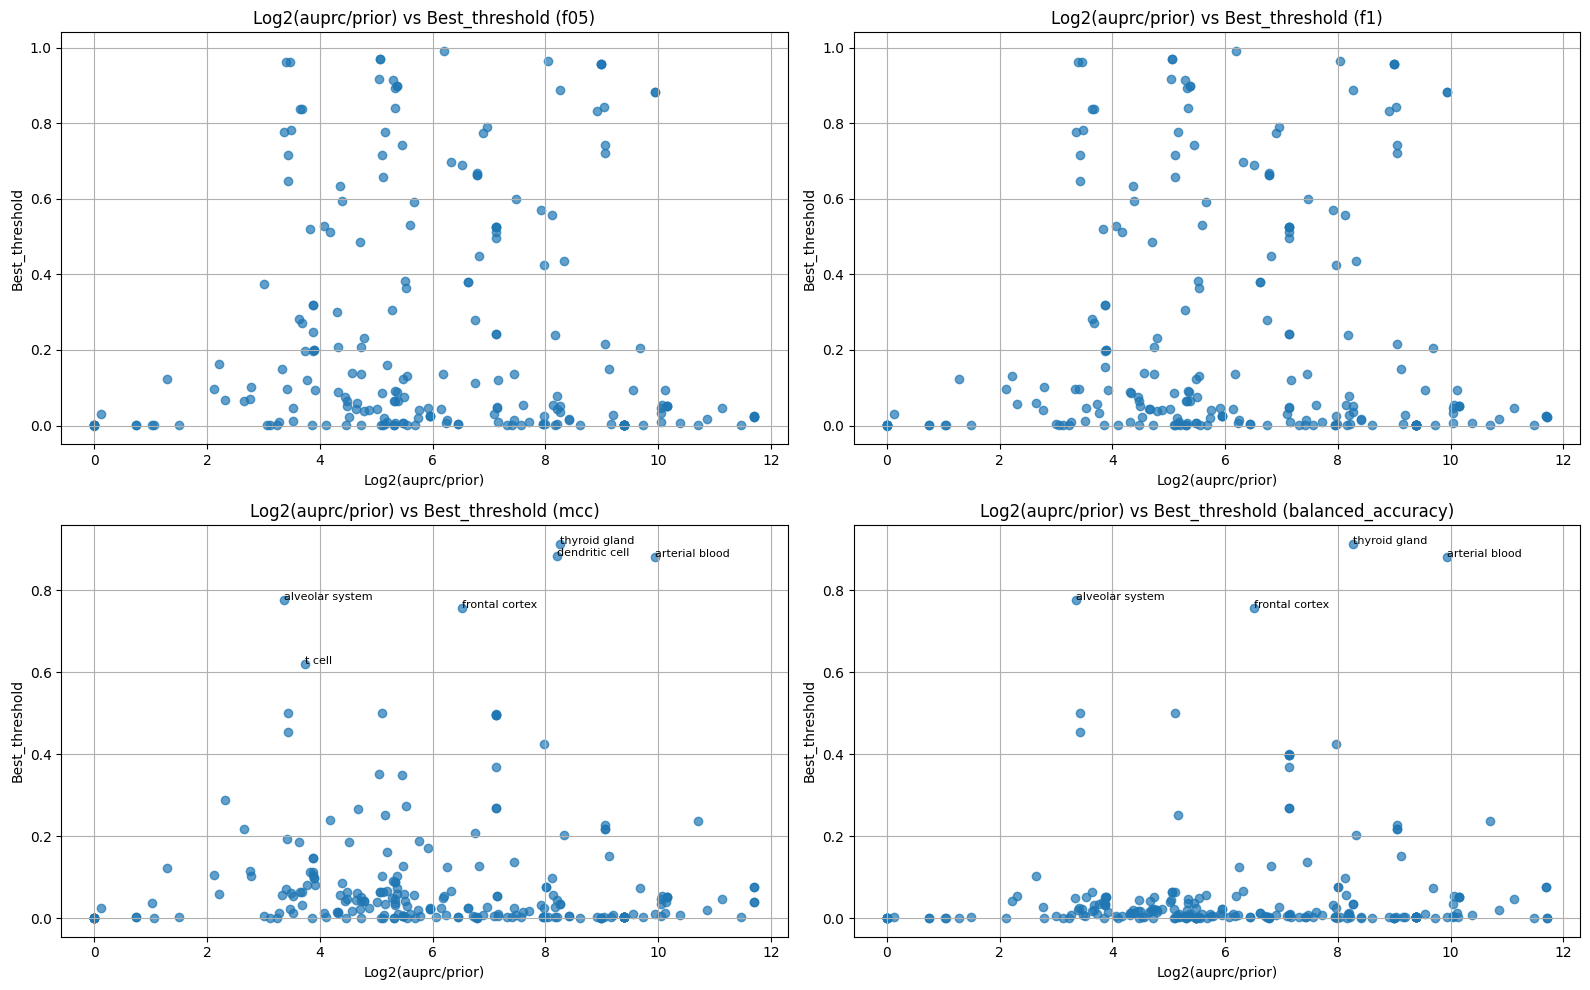

In [19]:
# log2(auprc/prior) vs best_threshold
methods = ["f05", "f1", "mcc", "balanced_accuracy"]
x_axis = "log2(auprc/prior)"
y_axis = "best_threshold"
plt.figure(figsize=(16, 10))

for i, method in enumerate(methods, 1):
    subset = txt2onto_label_df[txt2onto_label_df["method"] == method]
    plt.subplot(2, 2, i)
    plt.scatter(subset[x_axis], subset[y_axis], alpha=0.7)
    if method in ["balanced_accuracy", "mcc"]:
        for i, row in subset.iterrows():
            if row[y_axis] > 0.6:
                plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    plt.xlabel(x_axis.capitalize())
    plt.ylabel(y_axis.capitalize())
    plt.title(f'{x_axis.capitalize()} vs {y_axis.capitalize()} ({method})')
    plt.grid(True)

plt.tight_layout()
plt.show()

### sampleLASSO microarray: predicted annotations

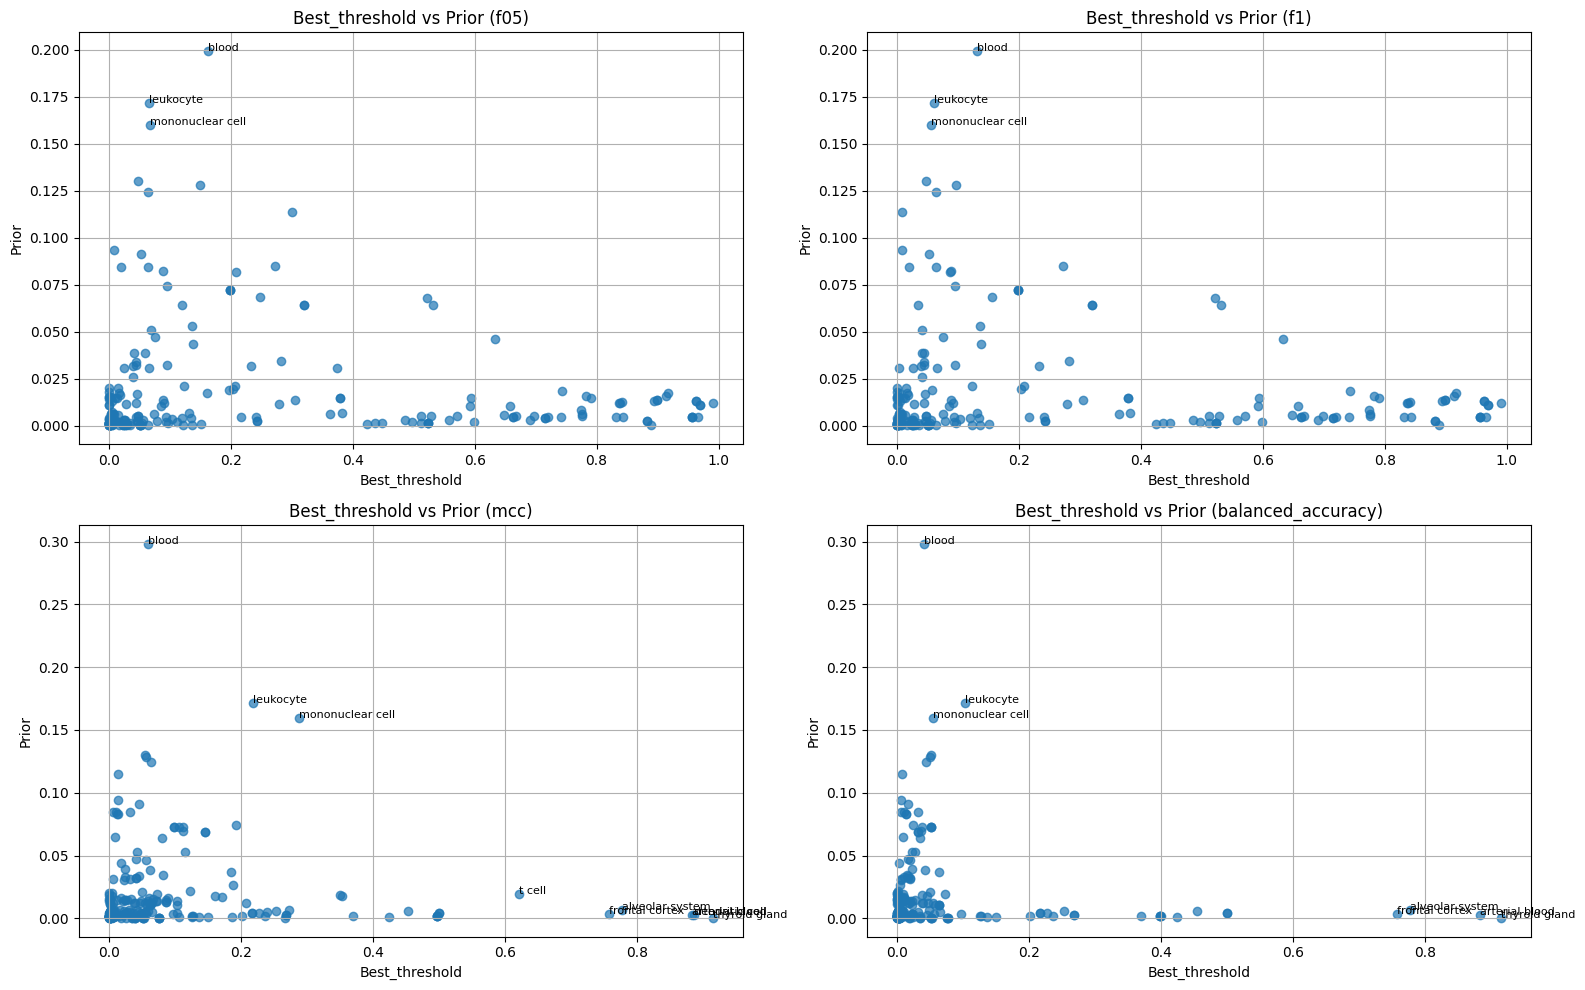

In [11]:
# best_threshold vs Prior
methods = ["f05", "f1", "mcc", "balanced_accuracy"]
x_axis = "best_threshold"
y_axis = "prior"
plt.figure(figsize=(16, 10))

for i, method in enumerate(methods, 1):
    subset = annotation_analysis_df[annotation_analysis_df["method"] == method]
    plt.subplot(2, 2, i)
    plt.scatter(subset[x_axis], subset[y_axis], alpha=0.7)
    for i, row in subset.iterrows():
        if row[y_axis] > 0.15:
            plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    if method in ["balanced_accuracy", "mcc"]:
        for i, row in subset.iterrows():
            if row[x_axis] > 0.6:
                plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    plt.xlabel(x_axis.capitalize())
    plt.ylabel(y_axis.capitalize())
    plt.title(f'{x_axis.capitalize()} vs {y_axis.capitalize()} ({method})')
    plt.grid(True)

plt.tight_layout()
plt.show()


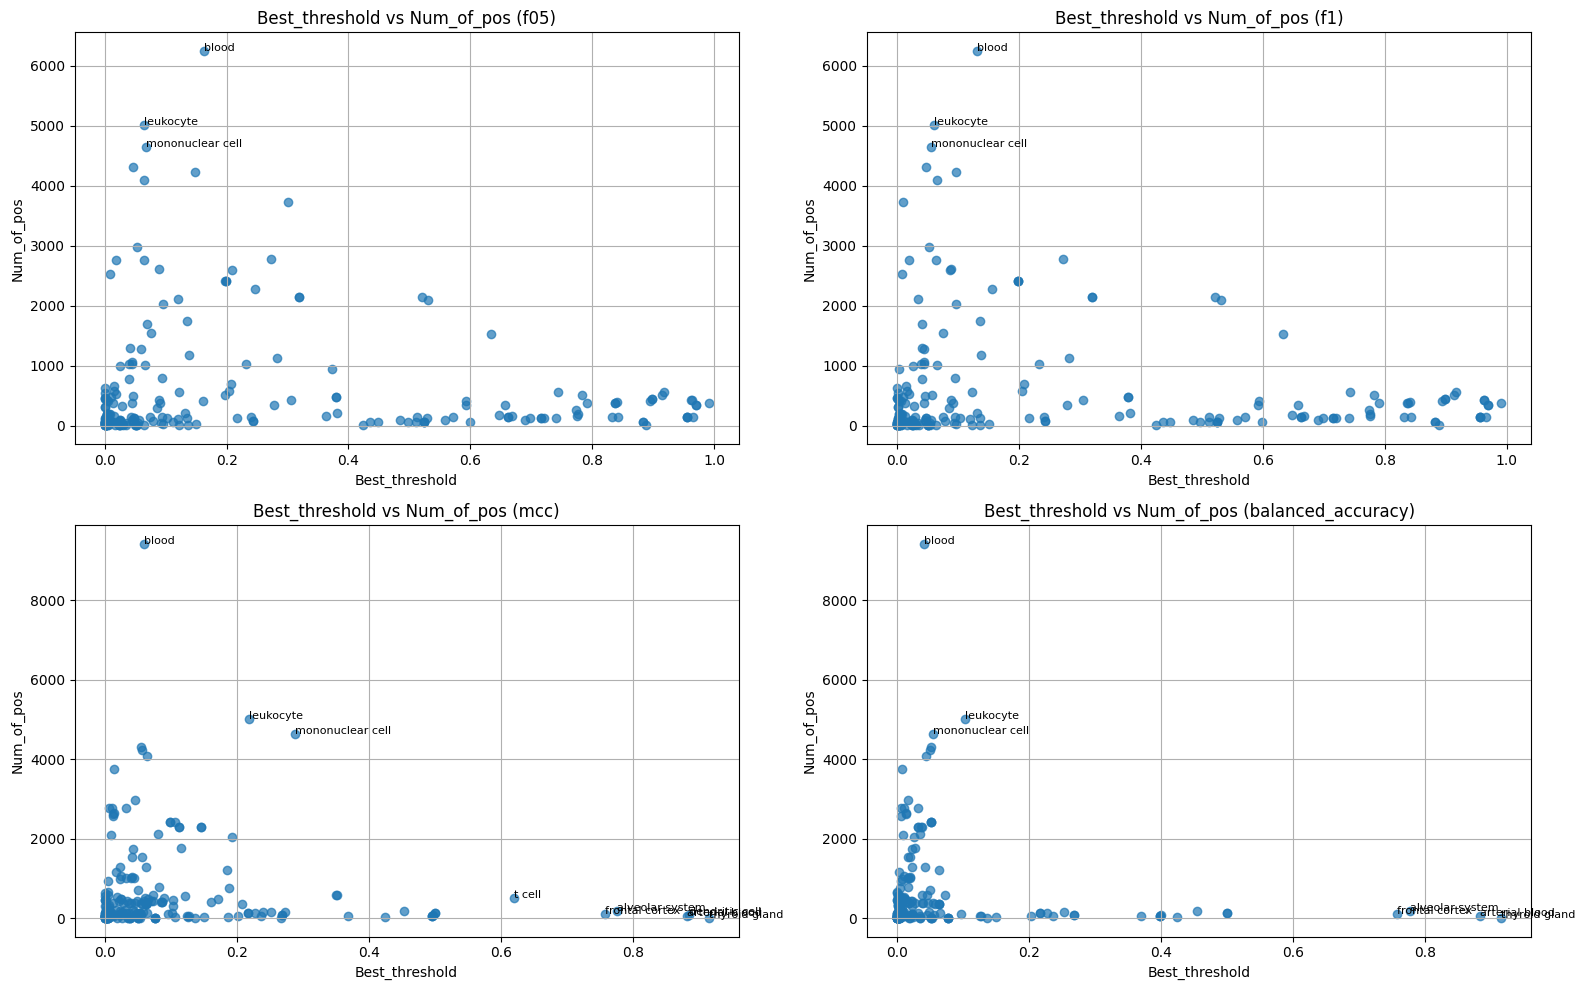

In [12]:
# best_threshold vs Number of Positives
methods = ["f05", "f1", "mcc", "balanced_accuracy"]
x_axis = "best_threshold"
y_axis = "num_of_pos"
plt.figure(figsize=(16, 10))

for i, method in enumerate(methods, 1):
    subset = annotation_analysis_df[annotation_analysis_df["method"] == method]
    plt.subplot(2, 2, i)
    plt.scatter(subset[x_axis], subset[y_axis], alpha=0.7)
    for i, row in subset.iterrows():
        if row[y_axis] > 4500:
            plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    if method in ["balanced_accuracy", "mcc"]:
        for i, row in subset.iterrows():
            if row[x_axis] > 0.6:
                plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    plt.xlabel(x_axis.capitalize())
    plt.ylabel(y_axis.capitalize())
    plt.title(f'{x_axis.capitalize()} vs {y_axis.capitalize()} ({method})')
    plt.grid(True)

plt.tight_layout()
plt.show()

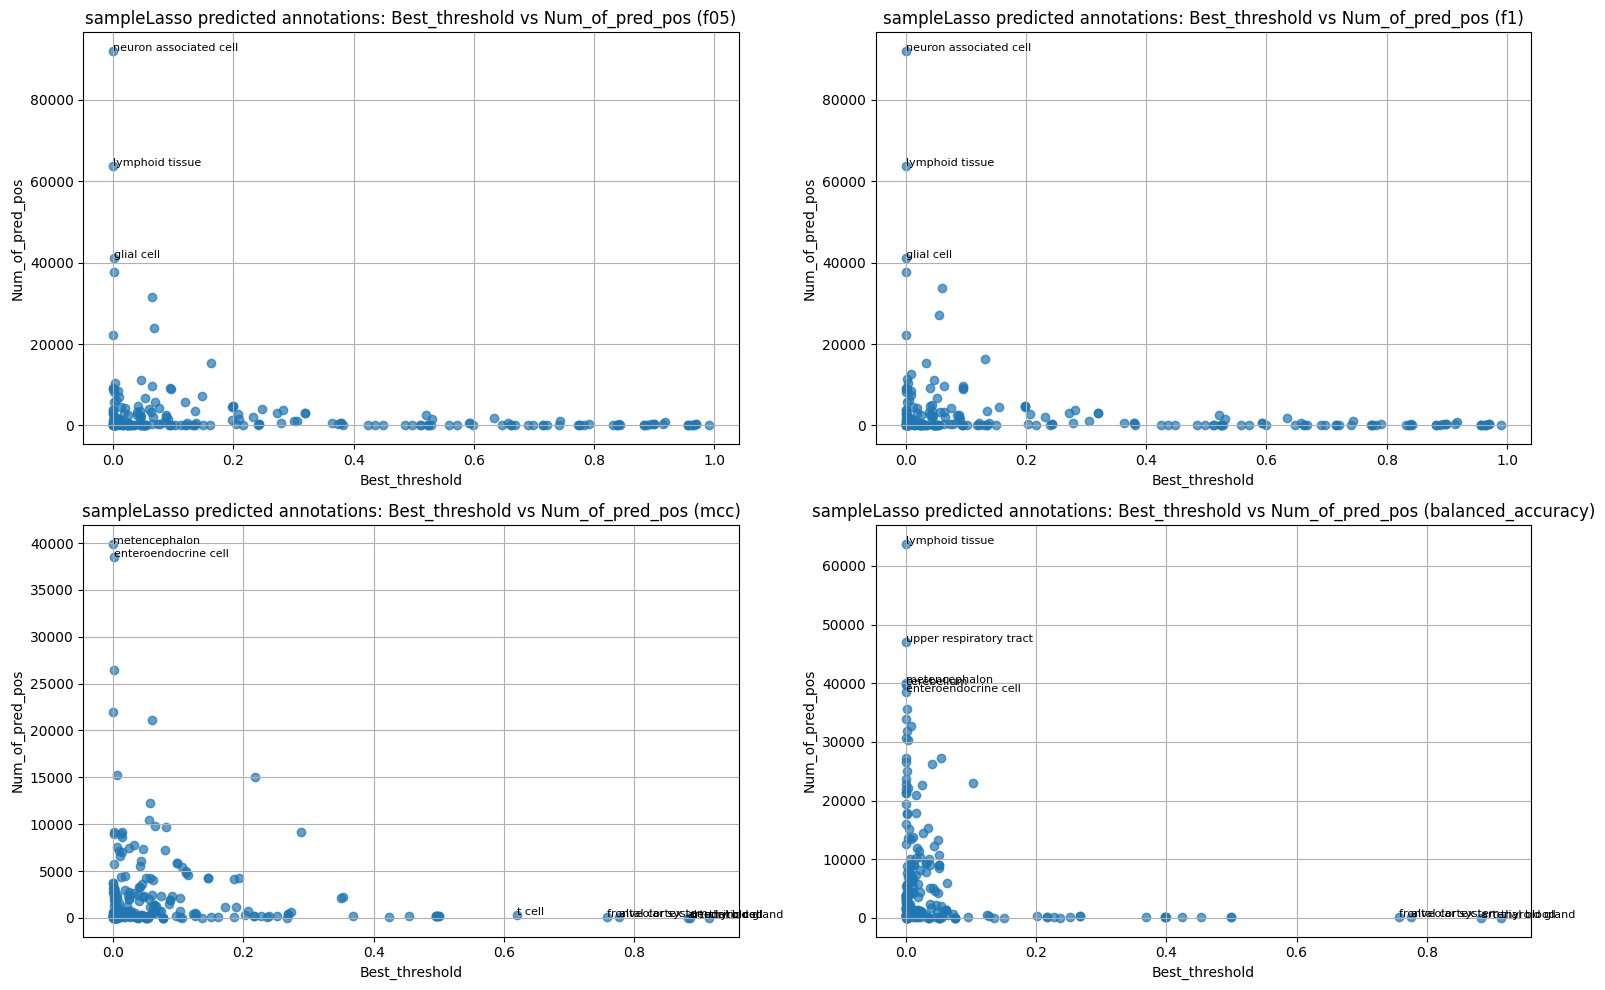

In [10]:
# best_threshold vs Number of Predicted Positives
methods = ["f05", "f1", "mcc", "balanced_accuracy"]
x_axis = "best_threshold"
y_axis = "num_of_pred_pos"
plt.figure(figsize=(16, 10))

for i, method in enumerate(methods, 1):
    subset = annotation_analysis_df[annotation_analysis_df["method"] == method]
    plt.subplot(2, 2, i)
    plt.scatter(subset[x_axis], subset[y_axis], alpha=0.7)
    for i, row in subset.iterrows():
        if row[y_axis] > 38000:
            plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    if method in ["balanced_accuracy", "mcc"]:
        for i, row in subset.iterrows():
            if row[x_axis] > 0.6:
                plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    plt.xlabel(x_axis.capitalize())
    plt.ylabel(y_axis.capitalize())
    plt.title(f'sampleLasso predicted annotations: {x_axis.capitalize()} vs {y_axis.capitalize()} ({method})')
    plt.grid(True)

plt.tight_layout()
plt.show()